<a href="https://colab.research.google.com/github/etesys/jon-taylor-example-scripts/blob/master/Copy_of_Stock_Data_Transform_Examples_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install yfinance
# Install ta-lib
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

     |████████████████████████████████| 6.4 MB 7.3 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Selecting previously unselected package libta-lib0.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting prev

In [4]:
import yfinance as yfinance
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import talib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style('darkgrid')
from datetime import datetime

print(f'talib version {talib.__version__}')
print(f'numpy version {np.__version__}')
print(f'pandas version {pd.__version__}')

talib version 0.4.24
numpy version 1.19.5
pandas version 1.1.5


In [5]:
# For simplicity and demonstration purposes we'll use just five tickers
symbols = 'AAPL INTC MSFT AMZN FB'

In [7]:
# Get the data
raw_data = yfinance.download(
    symbols, 
    start='2010-01-01',
    end='2021-04-24',
    threads=True
)

raw_data.head()

[*********************100%***********************]  5 of 5 completed


Adj Close                     ...    Volume                        
                AAPL    AMZN  FB   INTC  ...      AMZN  FB      INTC      MSFT
Date                                     ...                                  
2010-01-04     6.553 133.900 nan 14.577  ...   7599900 nan  47800900  38409100
2010-01-05     6.564 134.690 nan 14.570  ...   8851900 nan  52357700  49749600
2010-01-06     6.460 132.250 nan 14.521  ...   7178800 nan  40037400  58182400
2010-01-07     6.448 130.000 nan 14.381  ...  11030200 nan  54041500  50559700
2010-01-08     6.491 133.520 nan 14.542  ...   9830500 nan  48234700  51197400

[5 rows x 30 columns]

In [8]:
# Unstack the OHLCV data
df_close = raw_data['Adj Close'].stack().reset_index()
df_close.columns = columns = ['date', 'ticker', 'close']

df_volume = raw_data['Volume'].stack().reset_index()
df_volume.columns = ['date', 'ticker', 'volume']

df_high = raw_data['High'].stack().reset_index()
df_high.columns = ['date', 'ticker', 'high']

df_low = raw_data['Low'].stack().reset_index()
df_low.columns = ['date', 'ticker', 'low']

df_open = raw_data['Open'].stack().reset_index()
df_open.columns = ['date', 'ticker', 'open']

In [9]:
# Merge all the seperate dfs into one after unstacking
def multiple_df_merge(df_list, on, how):
    merged = df_list[0]
    for df_ in df_list[1:]:    
        merged = merged.merge(
            df_,
            on=on,
            how=how)
        merged = merged.fillna(0)
    return merged


df_list = [
    df_close,
    df_volume,
    df_high,
    df_low,
    df_open
]

df = multiple_df_merge(
    df_list,
    on=['date','ticker'],
    how='inner'
)

# The data should be sorted by date (ascending) but just make sure as all the following calcs assume this order
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

print(df.shape)
df.head()

(13631, 7)


,date,ticker,close,volume,high,low,open
0,2010-01-04,AAPL,6.553,493729600.000,7.661,7.585,7.622
1,2010-01-04,AMZN,133.900,7599900.000,136.610,133.140,136.250
2,2010-01-04,INTC,14.577,47800900.000,21.030,20.730,20.790
3,2010-01-04,MSFT,23.905,38409100.000,31.100,30.590,30.620
4,2010-01-05,AAPL,6.564,601904800.000,7.700,7.616,7.664


### Date Transfroms

In [10]:
# Create categorical values for different parts of the date
df['year'] = df['date'].dt.year
df['qtr'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week
df['dow'] = df['date'].dt.dayofweek
df.tail()

,date,ticker,close,volume,high,low,open,year,qtr,month,week,dow
13629,2021-04-23,INTC,58.093,77479500.000,60.000,57.900,59.160,2021,2,4,16,4
13626,2021-04-23,AAPL,133.697,78657500.000,135.120,132.160,132.160,2021,2,4,16,4
13627,2021-04-23,AMZN,3340.880,3192800.000,3375.000,3308.500,3319.100,2021,2,4,16,4
13628,2021-04-23,FB,301.130,17536800.000,302.590,297.150,298.760,2021,2,4,16,4
13630,2021-04-23,MSFT,259.576,21462600.000,261.510,257.270,257.880,2021,2,4,16,4


### Lagged Values

In [11]:
# Do it for OHLCV
ohlcv = ['open','high', 'low', 'close', 'volume']

for metric in ohlcv:
    days = 5
    for day in range(1, days + 1):
        df[f'{metric}_{day}'] = df.groupby('ticker')[metric].transform(lambda x: x.shift(day))

# For display purposes just showing AAPL
display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'close', 'close_1', 'close_2', 'close_3', 'close_4', 'close_5']]
display.tail(10)

,date,ticker,close,close_1,close_2,close_3,close_4,close_5
13581,2021-04-12,AAPL,130.631,132.383,129.755,127.306,125.624,125.316
13586,2021-04-13,AAPL,133.806,130.631,132.383,129.755,127.306,125.624
13591,2021-04-14,AAPL,131.417,133.806,130.631,132.383,129.755,127.306
13596,2021-04-15,AAPL,133.876,131.417,133.806,130.631,132.383,129.755
13601,2021-04-16,AAPL,133.537,133.876,131.417,133.806,130.631,132.383
13606,2021-04-19,AAPL,134.214,133.537,133.876,131.417,133.806,130.631
13611,2021-04-20,AAPL,132.492,134.214,133.537,133.876,131.417,133.806
13616,2021-04-21,AAPL,132.880,132.492,134.214,133.537,133.876,131.417
13621,2021-04-22,AAPL,131.328,132.880,132.492,134.214,133.537,133.876
13626,2021-04-23,AAPL,133.697,131.328,132.880,132.492,134.214,133.537


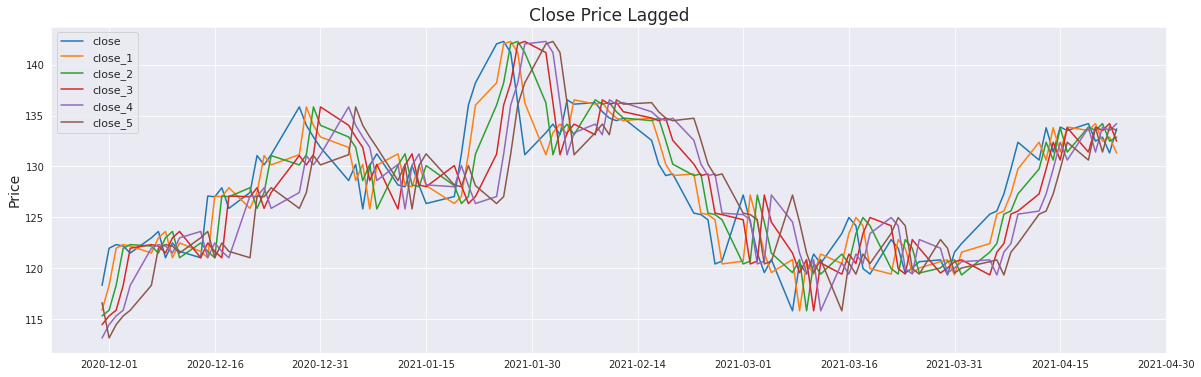

In [12]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(100)

graph_metrics = ['close', 'close_1', 'close_2', 'close_3', 'close_4', 'close_5']

fig, ax = plt.subplots(figsize=(20,6))

for metric in graph_metrics:
    ax.plot(example[metric], label=metric)

ax.set_title('Close Price Lagged', fontsize=17)
ax.set_ylabel('Price', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.legend(fontsize=11, loc='upper left')
plt.show()

### Rolling Statistics

In [13]:
# Create whatever lookback periods you want
lookback = 4

# Do it for OHLCV
for metric in ohlcv:
    # Average
    df[f'rolling_avg_{metric}_{str(lookback)}'] = df.groupby('ticker')[metric].transform(lambda s: s.rolling(lookback).mean())
    
    # Standard Deviation
    df[f'rolling_std_{metric}_{str(lookback)}'] = df.groupby('ticker')[metric].transform(lambda s: s.rolling(lookback).std())
    
    # Median
    df[f'rolling_median_{metric}_{str(lookback)}'] = df.groupby('ticker')[metric].transform(lambda s: s.rolling(lookback).median())
    
    # Min
    df[f'rolling_min_{metric}_{str(lookback)}'] = df.groupby('ticker')[metric].transform(lambda s: s.rolling(lookback).min())
    
    # Max
    df[f'rolling_max_{metric}_{str(lookback)}'] = df.groupby('ticker')[metric].transform(lambda s: s.rolling(lookback).max())
    
    # Absolute Difference
    df[f'diff_{metric}_1'] = df.groupby('ticker')[metric].diff()
    df[f'diff_{metric}_{str(lookback)}'] = df.groupby('ticker')[metric].diff(lookback)

    # Percent Change
    df[f'{metric}_pct_change_1'] = df.groupby('ticker')[metric].pct_change()
    df[f'{metric}_pct_change_{str(lookback)}'] = df.groupby('ticker')[metric].pct_change(lookback)

# Log Return
df['log_ret_1'] = df.groupby('ticker')['close'].apply(lambda x: np.log(x) - np.log(x.shift(1)))
df[f'log_ret_{str(lookback)}'] = df.groupby('ticker')['close'].apply(lambda x: np.log(x) - np.log(x.shift(lookback)))

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'close', f'diff_{metric}_{str(lookback)}', f'rolling_avg_{metric}_{str(lookback)}', 
                   f'rolling_std_{metric}_{str(lookback)}', f'rolling_median_{metric}_{str(lookback)}',
                   f'rolling_min_{metric}_{str(lookback)}', f'rolling_max_{metric}_{str(lookback)}',
                   'log_ret_1', 'close_pct_change_1']]
display.tail(10)

,date,ticker,close,diff_volume_4,rolling_avg_volume_4,rolling_std_volume_4,rolling_median_volume_4,rolling_min_volume_4,rolling_max_volume_4,log_ret_1,close_pct_change_1
13581,2021-04-12,AAPL,130.631,11248700.000,92604500.000,9955695.756,90132300.000,83466700.000,106686700.000,-0.013,-0.013
13586,2021-04-13,AAPL,133.806,7799800.000,94554450.000,8173723.531,91343250.000,88844600.000,106686700.000,0.024,0.024
13591,2021-04-14,AAPL,131.417,-1621800.000,94149000.000,8581422.085,91343250.000,87222800.000,106686700.000,-0.018,-0.018
13596,2021-04-15,AAPL,133.876,-17339600.000,89814100.000,1968189.122,90306800.000,87222800.000,91420000.000,0.019,0.019
13601,2021-04-16,AAPL,133.537,-6497600.000,88189700.000,2733521.410,88284950.000,84922400.000,91266500.000,-0.003,-0.003
13606,2021-04-19,AAPL,134.214,2997700.000,88939125.000,3983412.213,88284950.000,84922400.000,94264200.000,0.005,0.005
13611,2021-04-20,AAPL,132.492,7589500.000,90836500.000,4645822.643,91805650.000,84922400.000,94812300.000,-0.013,-0.013
13616,2021-04-21,AAPL,132.880,-20500000.000,85711500.000,12124409.320,89593300.000,68847100.000,94812300.000,0.003,0.003
13621,2021-04-22,AAPL,131.328,-355900.000,85622525.000,12133432.931,89415350.000,68847100.000,94812300.000,-0.012,-0.012
13626,2021-04-23,AAPL,133.697,-15606700.000,81720850.000,10872002.871,81612000.000,68847100.000,94812300.000,0.018,0.018


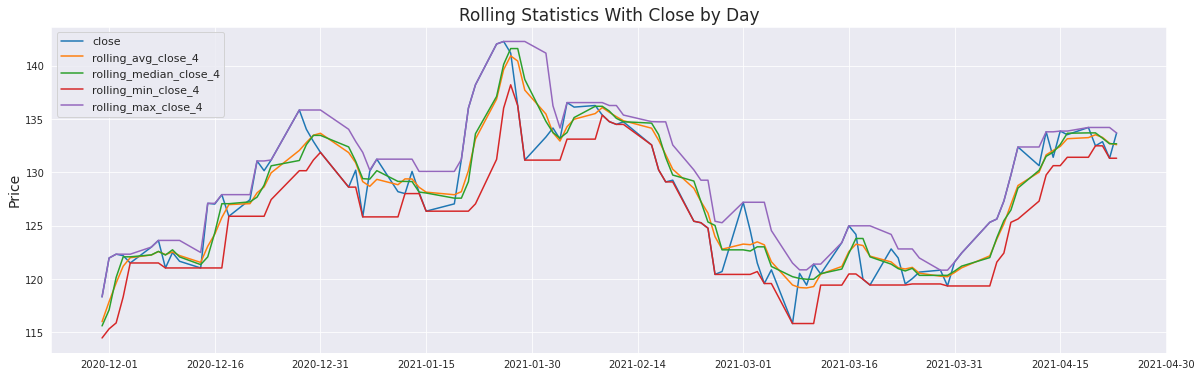

In [14]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(100)

graph_metrics = ['close', f'rolling_avg_close_{str(lookback)}', 
                 f'rolling_median_close_{str(lookback)}', f'rolling_min_close_{str(lookback)}', 
                 f'rolling_max_close_{str(lookback)}']

fig, ax = plt.subplots(figsize=(20,6))

for metric in graph_metrics:
    ax.plot(example[metric], label=metric)

ax.set_title('Rolling Statistics With Close by Day', fontsize=17)
ax.set_ylabel('Price', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.legend(fontsize=11, loc='upper left')
plt.show()

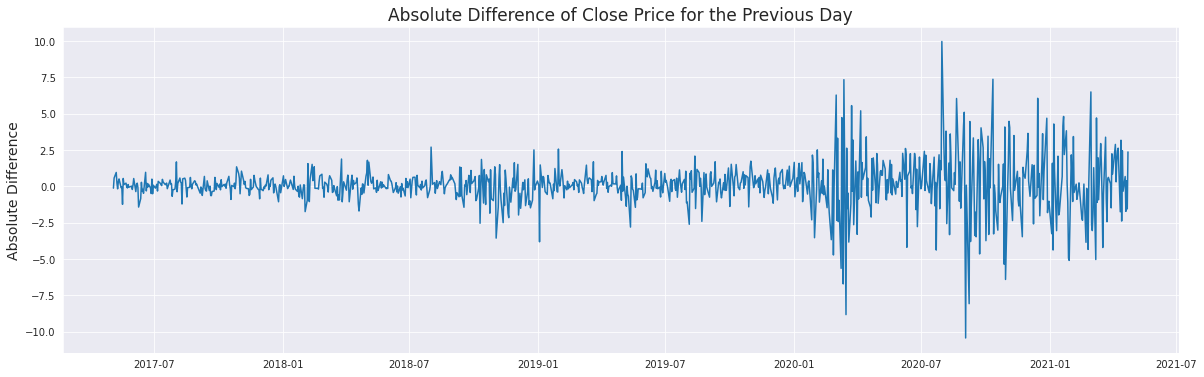

In [15]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(1000)

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(example['diff_close_1'])
ax.set_title('Absolute Difference of Close Price for the Previous Day', fontsize=17)
ax.set_ylabel('Absolute Difference', fontsize=14)

plt.show()

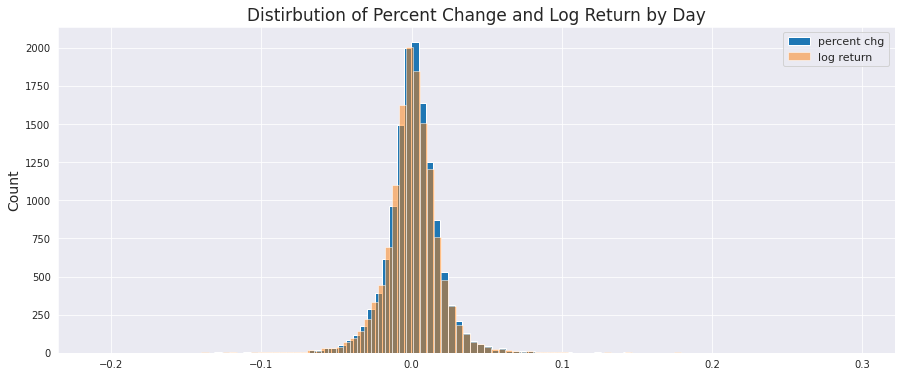

In [16]:
y1 = df['close_pct_change_1']
y2 = df['log_ret_1']

fig, ax = plt.subplots(figsize=(15,6))

ax.hist(y1, bins=100, alpha=1.0, label='percent chg')
ax.hist(y2, bins=100, alpha=0.5, label='log return')

ax.set_title('Distirbution of Percent Change and Log Return by Day', fontsize=17)
ax.set_ylabel('Count', fontsize=14)
ax.legend(loc='upper right', fontsize=11)

plt.show()

### Trend Indicators


In [17]:
# Moving averages
lookback_fast = 4
lookback_slow = 12

for metric in ohlcv:
    # Exponential Moving Avg
    df[f'{metric}_ema_{str(lookback_fast)}'] = df.groupby('ticker')[metric].transform(lambda x: talib.EMA(x, timeperiod=lookback_fast))
    df[f'{metric}_ema_{str(lookback_slow)}'] = df.groupby('ticker')[metric].transform(lambda x: talib.EMA(x, timeperiod=lookback_slow))

    # Double Exponential Moving Average
    df[f'{metric}_dema_{str(lookback_fast)}'] = df.groupby('ticker')[metric].transform(lambda x: talib.DEMA(x, timeperiod=lookback_fast))
    df[f'{metric}_dema_{str(lookback_slow)}'] = df.groupby('ticker')[metric].transform(lambda x: talib.DEMA(x, timeperiod=lookback_slow))

    # Triple Exponential Moving Average
    df[f'{metric}_tema_{str(lookback_fast)}'] = df.groupby('ticker')[metric].transform(lambda x: talib.TEMA(x, timeperiod=lookback_fast))
    df[f'{metric}_tema_{str(lookback_slow)}'] = df.groupby('ticker')[metric].transform(lambda x: talib.TEMA(x, timeperiod=lookback_slow))

    # Trinagular Moving Average
    df[f'{metric}_trima_{str(lookback_fast)}'] = df.groupby('ticker')[metric].transform(lambda x: talib.TRIMA(x, timeperiod=lookback_fast))
    df[f'{metric}_trima_{str(lookback_slow)}'] = df.groupby('ticker')[metric].transform(lambda x: talib.TRIMA(x, timeperiod=lookback_slow))

    # Weighted Moving Average
    df[f'{metric}_wma_{str(lookback_fast)}'] = df.groupby('ticker')[metric].transform(lambda x: talib.WMA(x, timeperiod=lookback_fast))
    df[f'{metric}_wma_{str(lookback_slow)}'] = df.groupby('ticker')[metric].transform(lambda x: talib.WMA(x, timeperiod=lookback_slow))

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'close', f'close_ema_{str(lookback_fast)}', f'close_ema_{str(lookback_slow)}']] 
display.tail(10)

,date,ticker,close,close_ema_4,close_ema_12
13581,2021-04-12,AAPL,130.631,129.783,126.255
13586,2021-04-13,AAPL,133.806,131.392,127.416
13591,2021-04-14,AAPL,131.417,131.402,128.032
13596,2021-04-15,AAPL,133.876,132.391,128.931
13601,2021-04-16,AAPL,133.537,132.850,129.640
13606,2021-04-19,AAPL,134.214,133.396,130.343
13611,2021-04-20,AAPL,132.492,133.034,130.674
13616,2021-04-21,AAPL,132.880,132.973,131.013
13621,2021-04-22,AAPL,131.328,132.315,131.062
13626,2021-04-23,AAPL,133.697,132.867,131.467


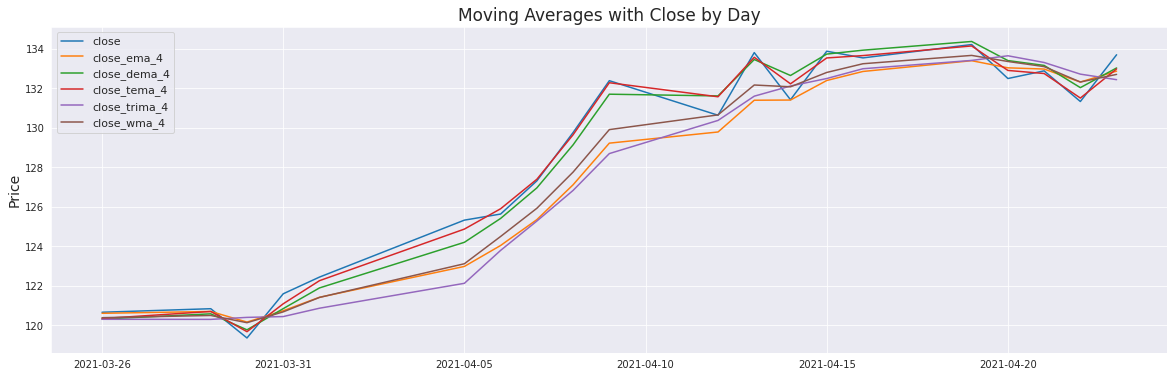

In [18]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(20)

graph_metrics = ['close', f'close_ema_{str(lookback_fast)}', f'close_dema_{str(lookback_fast)}', 
                 f'close_tema_{str(lookback_fast)}', f'close_trima_{str(lookback_fast)}', f'close_wma_{str(lookback_fast)}']

fig, ax = plt.subplots(figsize=(20,6))

for metric in graph_metrics:
    ax.plot(example[metric], label=metric)

ax.set_title('Moving Averages with Close by Day', fontsize=17)
ax.set_ylabel('Price', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.legend(fontsize=11, loc='upper left')
plt.show()

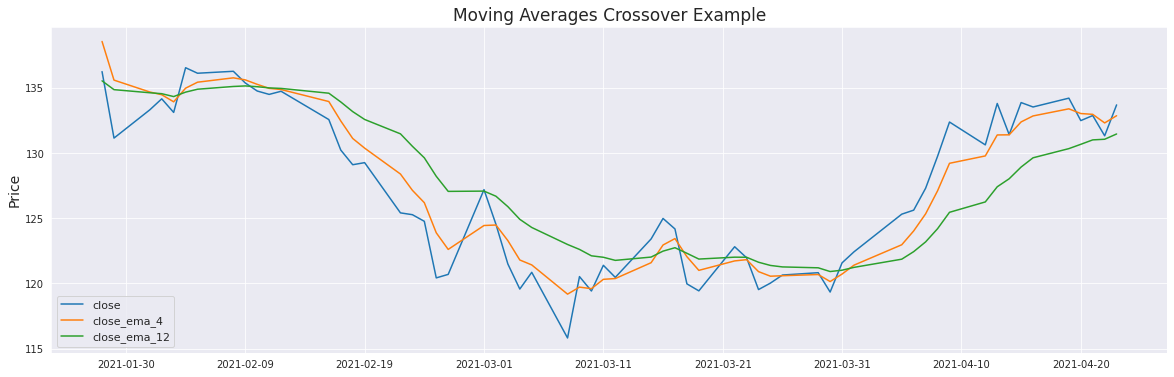

In [19]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(60)

graph_metrics = ['close', f'close_ema_{str(lookback_fast)}', f'close_ema_{str(lookback_slow)}']

fig, ax = plt.subplots(figsize=(20,6))

for metric in graph_metrics:
    ax.plot(example[metric], label=metric)

ax.set_title('Moving Averages Crossover Example', fontsize=17)
ax.set_ylabel('Price', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.legend(fontsize=11, loc='lower left')
plt.show()

In [20]:
# To create a categorical variable for the ma crossover
# If the slow period is above the fast period set it to 1, else set it to 0
conditions = [
    df[f'close_ema_{str(lookback_slow)}'] > df[f'close_ema_{str(lookback_fast)}'],
    df[f'close_ema_{str(lookback_slow)}'] < df[f'close_ema_{str(lookback_fast)}'],
]

choices = [1, 0]

df['sma_crossover'] = np.select(
    conditions,
    choices,
    default=np.nan
)

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'close', f'close_ema_{str(lookback_slow)}',  f'close_ema_{str(lookback_fast)}', 'sma_crossover']] 
display.tail(20)

,date,ticker,close,close_ema_12,close_ema_4,sma_crossover
13531,2021-03-26,AAPL,120.647,121.270,120.593,1.000
13536,2021-03-29,AAPL,120.827,121.202,120.687,1.000
13541,2021-03-30,AAPL,119.343,120.916,120.149,1.000
13546,2021-03-31,AAPL,121.583,121.019,120.723,1.000
13551,2021-04-01,AAPL,122.429,121.236,121.405,0.000
13556,2021-04-05,AAPL,125.316,121.863,122.969,0.000
13561,2021-04-06,AAPL,125.624,122.442,124.031,0.000
13566,2021-04-07,AAPL,127.306,123.190,125.341,0.000
13571,2021-04-08,AAPL,129.755,124.200,127.107,0.000
13576,2021-04-09,AAPL,132.383,125.459,129.217,0.000


In [21]:
# Bollinger Bands
df['bb_upper'] = df.groupby('ticker')['close'].transform(lambda x: talib.BBANDS(x, timeperiod=5, nbdevup=1.5, nbdevdn=1.5, matype=0)[0])
df['bb_lower'] = df.groupby('ticker')['close'].transform(lambda x: talib.BBANDS(x, timeperiod=5, nbdevup=1.5, nbdevdn=1.5, matype=0)[2])

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'close', 'bb_upper', 'bb_lower']] 
display.tail(10)

,date,ticker,close,bb_upper,bb_lower
13581,2021-04-12,AAPL,130.631,132.742,125.537
13586,2021-04-13,AAPL,133.806,134.121,127.431
13591,2021-04-14,AAPL,131.417,133.704,129.492
13596,2021-04-15,AAPL,133.876,134.349,130.496
13601,2021-04-16,AAPL,133.537,134.691,130.616
13606,2021-04-19,AAPL,134.214,134.870,131.870
13611,2021-04-20,AAPL,132.492,134.642,131.572
13616,2021-04-21,AAPL,132.880,134.349,132.451
13621,2021-04-22,AAPL,131.328,134.356,131.425
13626,2021-04-23,AAPL,133.697,134.422,131.422


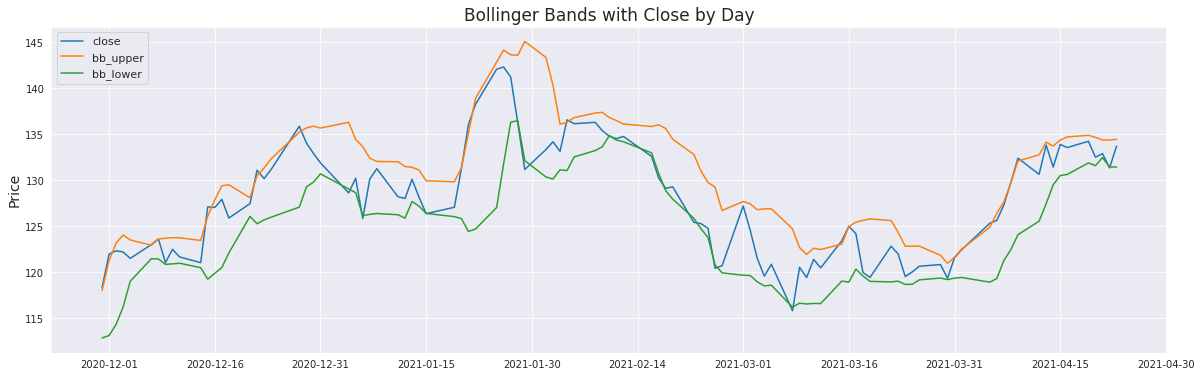

In [22]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(100)

graph_metrics = [ 'close', 'bb_upper', 'bb_lower']

fig, ax = plt.subplots(figsize=(20,6))

for metric in graph_metrics:
    ax.plot(example[metric], label=metric)

ax.set_title('Bollinger Bands with Close by Day', fontsize=17)
ax.set_ylabel('Price', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.legend(fontsize=11, loc='upper left')
plt.show()

In [23]:
# To create a categorical variable for the BB indicator
# If the close price moves above the upper bound set it to -1, if it moves below the lower bound set it to 1 (buy, buy ,buy11!!!), else 0
conditions = [
    df['close'] > df['bb_upper'],
    df['close'] < df['bb_lower'],
]

choices = [-1, 1]

df['bb_indicator'] = np.select(
    conditions,
    choices,
    default=0
)

example = df[['ticker', 'close', 'bb_upper', 'bb_lower', 'bb_indicator']] 
example.tail(10)

,ticker,close,bb_upper,bb_lower,bb_indicator
13621,AAPL,131.328,134.356,131.425,1
13622,AMZN,3309.040,3402.096,3308.784,0
13623,FB,296.520,306.464,297.160,1
13624,INTC,61.359,63.403,61.079,0
13625,MSFT,255.620,259.585,255.487,0
13629,INTC,58.093,63.560,58.761,1
13626,AAPL,133.697,134.422,131.422,0
13627,AMZN,3340.880,3376.779,3310.677,0
13628,FB,301.130,304.114,297.490,0
13630,MSFT,259.576,259.821,255.414,0


In [24]:
# Typical price 
typical_price = df.groupby('ticker').apply(lambda x: talib.TYPPRICE(x['high'], x['low'], x['close'])).reset_index()
df = pd.merge(
    df, typical_price.drop('ticker', axis=1).set_index('level_1'), left_index=True, right_index=True, how='inner'
    ).rename(columns={0: 'typical_price'})

# Weighted close price
weighted_close = df.groupby('ticker').apply(lambda x: talib.WCLPRICE(x['high'], x['low'], x['close'])).reset_index()
df = pd.merge(
    df, weighted_close.drop('ticker', axis=1).set_index('level_1'), left_index=True, right_index=True, how='inner'
    ).rename(columns={0: 'weighted_close'})

# Midpoint
df['mid_point'] = df.groupby('ticker')['close'].transform(lambda x: talib.MIDPOINT(x, timeperiod=14))

# Mid price
mid_price = df.groupby('ticker').apply(lambda x: talib.MIDPRICE(x['high'], x['low'], timeperiod=14)).reset_index()
df = pd.merge(
    df, mid_price.drop('ticker', axis=1).set_index('level_1'), left_index=True, right_index=True, how='inner'
    ).rename(columns={0: 'mid_price'})

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker',  'close', 'typical_price', 'weighted_close', 'mid_point', 'mid_price']] 
display.tail(10)

,date,ticker,close,typical_price,weighted_close,mid_point,mid_price
13581,2021-04-12,AAPL,130.631,131.370,131.185,125.863,125.950
13586,2021-04-13,AAPL,133.806,133.465,133.550,126.575,126.760
13591,2021-04-14,AAPL,131.417,132.692,132.374,126.575,126.930
13596,2021-04-15,AAPL,133.876,134.172,134.098,126.610,126.930
13601,2021-04-16,AAPL,133.537,133.829,133.756,126.610,126.930
13606,2021-04-19,AAPL,134.214,134.341,134.310,126.779,127.165
13611,2021-04-20,AAPL,132.492,133.277,133.081,127.899,128.340
13616,2021-04-21,AAPL,132.880,132.643,132.703,128.322,129.010
13621,2021-04-22,AAPL,131.328,132.296,132.054,129.765,129.300
13626,2021-04-23,AAPL,133.697,133.659,133.668,129.919,130.335


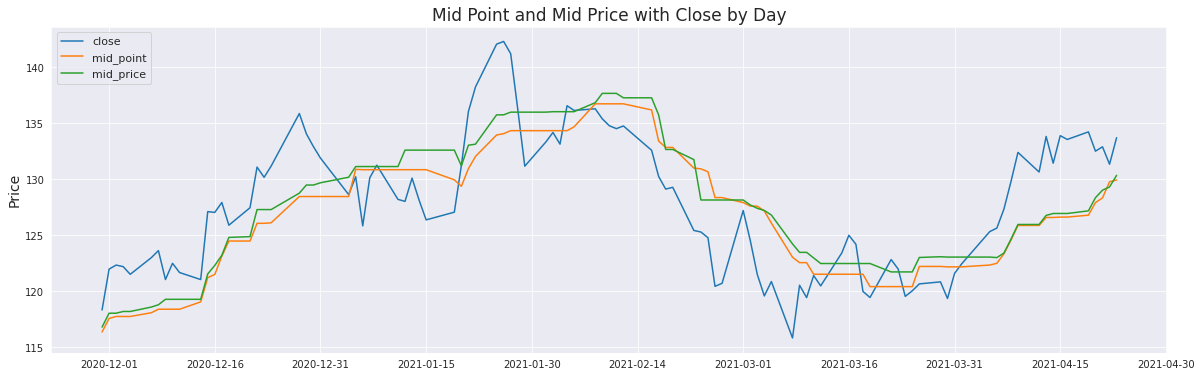

In [25]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(100)

graph_metrics = ['close', 'mid_point', 'mid_price']

fig, ax = plt.subplots(figsize=(20,6))

for metric in graph_metrics:
    ax.plot(example[metric], label=metric)

ax.set_title('Mid Point and Mid Price with Close by Day', fontsize=17)
ax.set_ylabel('Price', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.legend(fontsize=11, loc='upper left')
plt.show()

In [26]:
# Hilbert Transform - Instantaneous Trendline
df['ht_trendline'] = df.groupby('ticker')['close'].transform(lambda x: talib.HT_TRENDLINE(x))

# Parabolic SAR
sar = df.groupby('ticker').apply(lambda x: talib.SAR(x['high'], x['low'], acceleration=0, maximum=0)).reset_index()
df = pd.merge(
    df, mid_price.drop('ticker', axis=1).set_index('level_1'), left_index=True, right_index=True, how='inner'
    ).rename(columns={0: 'sar'})

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'close', 'ht_trendline', 'mid_point', 'mid_price', 'sar']] 
display.tail(10)

,date,ticker,close,ht_trendline,mid_point,mid_price,sar
13581,2021-04-12,AAPL,130.631,123.179,125.863,125.950,125.950
13586,2021-04-13,AAPL,133.806,123.849,126.575,126.760,126.760
13591,2021-04-14,AAPL,131.417,124.504,126.575,126.930,126.930
13596,2021-04-15,AAPL,133.876,125.209,126.610,126.930,126.930
13601,2021-04-16,AAPL,133.537,125.809,126.610,126.930,126.930
13606,2021-04-19,AAPL,134.214,126.492,126.779,127.165,127.165
13611,2021-04-20,AAPL,132.492,127.032,127.899,128.340,128.340
13616,2021-04-21,AAPL,132.880,127.451,128.322,129.010,129.010
13621,2021-04-22,AAPL,131.328,127.751,129.765,129.300,129.300
13626,2021-04-23,AAPL,133.697,127.999,129.919,130.335,130.335


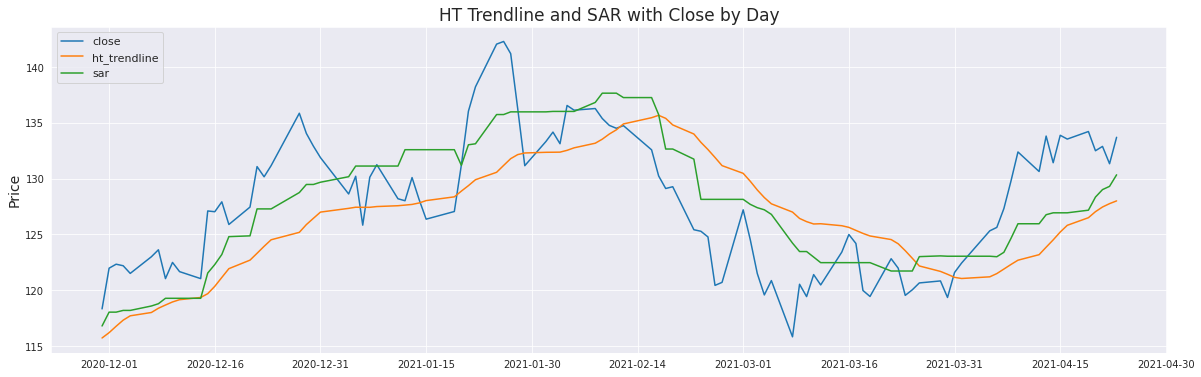

In [27]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(100)

graph_metrics = ['close', 'ht_trendline', 'sar']

fig, ax = plt.subplots(figsize=(20,6))

for metric in graph_metrics:
    ax.plot(example[metric], label=metric)

ax.set_title('HT Trendline and SAR with Close by Day', fontsize=17)
ax.set_ylabel('Price', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.legend(fontsize=11, loc='upper left')
plt.show()

### Volume Indicators

In [28]:
# Chaikin A/D Oscillator
adosc = df.groupby('ticker').apply(lambda x: talib.ADOSC(x['high'], x['low'], x['close'], x['volume'], fastperiod=3, slowperiod=10)).reset_index()
df = pd.merge(
    df, adosc.drop('ticker', axis=1).set_index('level_1'), left_index=True, right_index=True, how='inner'
    ).rename(columns={0: 'adosc'})

# On Balance Volume
obv = df.groupby('ticker').apply(lambda x: talib.OBV(x['close'], x['volume'])).reset_index()
df = pd.merge(
    df, obv.drop('ticker', axis=1).set_index('level_1'), left_index=True, right_index=True, how='inner'
    ).rename(columns={0: 'obv'})

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'volume', 'adosc', 'obv']] 
display.tail(10)

,date,ticker,volume,adosc,obv
13581,2021-04-12,AAPL,91420000.000,-67372316.949,17310066800.000
13586,2021-04-13,AAPL,91266500.000,-52329822.750,17401333300.000
13591,2021-04-14,AAPL,87222800.000,-73207708.977,17314110500.000
13596,2021-04-15,AAPL,89347100.000,-93669989.625,17403457600.000
13601,2021-04-16,AAPL,84922400.000,-110544145.273,17318535200.000
13606,2021-04-19,AAPL,94264200.000,-112774042.939,17412799400.000
13611,2021-04-20,AAPL,94812300.000,-122538115.967,17317987100.000
13616,2021-04-21,AAPL,68847100.000,-109038916.455,17386834200.000
13621,2021-04-22,AAPL,84566500.000,-122130645.059,17302267700.000
13626,2021-04-23,AAPL,78657500.000,-115427812.391,17380925200.000


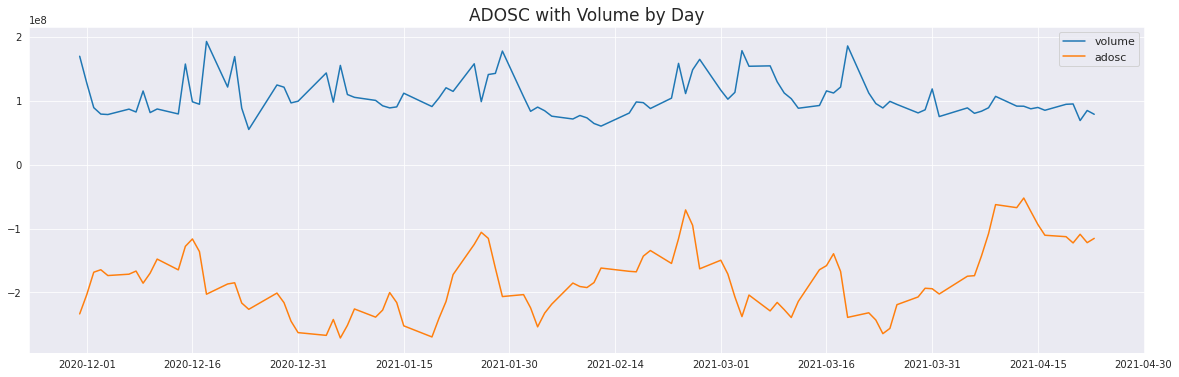

In [29]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(100)

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(example['volume'], label='volume')
ax.plot(example['adosc'], label='adosc')
ax.set_title('ADOSC with Volume by Day', fontsize=17)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.legend(fontsize=11)
plt.show()

### Statistical Functions

In [30]:
# Linear Regression
df['lin_reg'] = df.groupby('ticker')['close'].transform(lambda x: talib.LINEARREG(x, timeperiod=14))

# Linear Regression Angle
df['lin_reg_angle'] = df.groupby('ticker')['close'].transform(lambda x: talib.LINEARREG_ANGLE(x, timeperiod=14))

# Linear Regression Intercept
df['lin_reg_intercept'] = df.groupby('ticker')['close'].transform(lambda x: talib.LINEARREG_INTERCEPT(x, timeperiod=14))

# Linear Regression Slope
df['lin_reg_slope'] = df.groupby('ticker')['close'].transform(lambda x: talib.LINEARREG_SLOPE(x, timeperiod=14))

# Pearson's Correlation Coefficient (r)
corr = df.groupby('ticker').apply(lambda x: talib.CORREL(x['high'], x['low'])).reset_index()
df = pd.merge(
    df, corr.drop('ticker', axis=1).set_index('level_1'), left_index=True, right_index=True, how='inner'
    ).rename(columns={0: 'corr'})

# Beta
beta = df.groupby('ticker').apply(lambda x: talib.BETA(x['high'], x['low'], timeperiod=5)).reset_index()
df = pd.merge(
    df, beta.drop('ticker', axis=1).set_index('level_1'), left_index=True, right_index=True, how='inner'
    ).rename(columns={0: 'beta'})

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'close', 'lin_reg', 'lin_reg_angle', 'lin_reg_intercept', 'lin_reg_slope', 'corr', 'beta']] 
display.tail(10)

,date,ticker,close,lin_reg,lin_reg_angle,lin_reg_intercept,lin_reg_slope,corr,beta
13581,2021-04-12,AAPL,130.631,130.253,43.436,117.944,0.947,0.955,0.487
13586,2021-04-13,AAPL,133.806,132.445,49.091,117.442,1.154,0.971,0.584
13591,2021-04-14,AAPL,131.417,133.337,49.252,118.249,1.161,0.976,0.597
13596,2021-04-15,AAPL,133.876,134.592,50.232,118.971,1.202,0.980,-0.021
13601,2021-04-16,AAPL,133.537,135.453,50.015,119.952,1.192,0.985,0.309
13606,2021-04-19,AAPL,134.214,136.145,49.035,121.172,1.152,0.988,0.374
13611,2021-04-20,AAPL,132.492,135.800,43.658,123.395,0.954,0.990,-0.001
13616,2021-04-21,AAPL,132.880,135.499,38.088,125.310,0.784,0.991,0.255
13621,2021-04-22,AAPL,131.328,134.597,28.688,127.483,0.547,0.991,0.171
13626,2021-04-23,AAPL,133.697,134.462,23.479,128.816,0.434,0.991,0.367


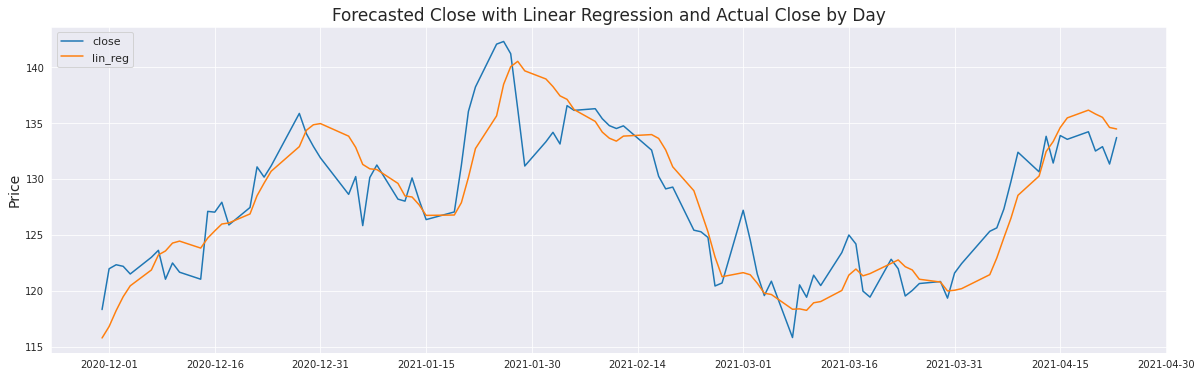

In [31]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(100)

graph_metrics = ['close', 'lin_reg',]

fig, ax = plt.subplots(figsize=(20,6))

for metric in graph_metrics:
    ax.plot(example[metric], label=metric)

ax.set_title('Forecasted Close with Linear Regression and Actual Close by Day', fontsize=17)
ax.set_ylabel('Price', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.legend(fontsize=11, loc='upper left')
plt.show()

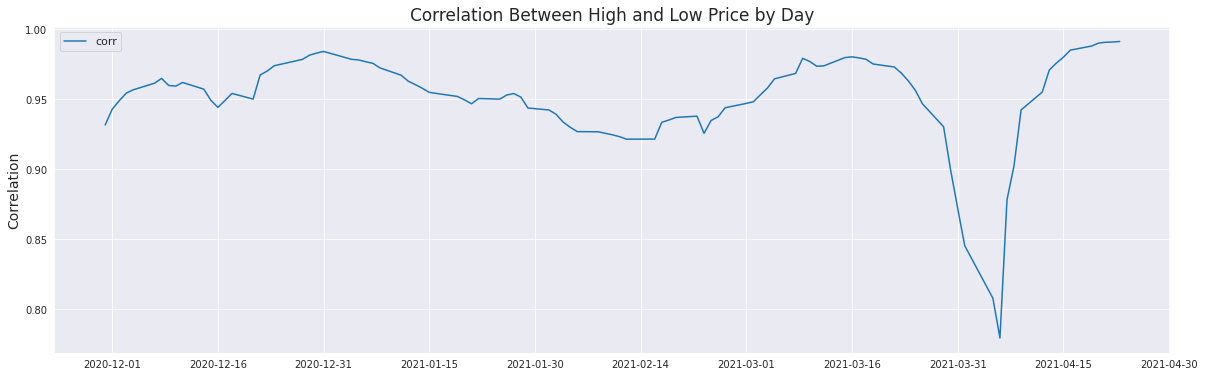

In [32]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(100)

graph_metrics = ['corr',]

fig, ax = plt.subplots(figsize=(20,6))

ax.plot(example['corr'], label='corr')

ax.set_title('Correlation Between High and Low Price by Day', fontsize=17)
ax.set_ylabel('Correlation', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.legend(fontsize=11, loc='upper left')
plt.show()

### Volatility Indicators

In [33]:
# Average True Range
atr = df.groupby('ticker').apply(lambda x: talib.ATR(x['high'], x['low'], x['close'], timeperiod=14)).reset_index()
df = pd.merge(
    df, atr.drop('ticker', axis=1).set_index('level_1'), left_index=True, right_index=True, how='inner'
    ).rename(columns={0: 'atr'})

# Annualized Volatility
df['annualized_vol'] = df.groupby('ticker')['log_ret_1'].transform(lambda s: s.rolling(window=252).std() * np.sqrt(252))

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'high', 'low', 'close', 'atr', 'annualized_vol']] 
display.tail(10)

,date,ticker,high,low,close,atr,annualized_vol
13581,2021-04-12,AAPL,132.850,130.630,130.631,3.145,0.356
13586,2021-04-13,AAPL,134.660,131.930,133.806,3.208,0.357
13591,2021-04-14,AAPL,135.000,131.660,131.417,3.217,0.354
13596,2021-04-15,AAPL,135.000,133.640,133.876,3.243,0.354
13601,2021-04-16,AAPL,134.670,133.280,133.537,3.111,0.354
13606,2021-04-19,AAPL,135.470,133.340,134.214,3.041,0.354
13611,2021-04-20,AAPL,135.530,131.810,132.492,3.089,0.354
13616,2021-04-21,AAPL,133.750,131.300,132.880,3.044,0.352
13621,2021-04-22,AAPL,134.150,131.410,131.328,3.022,0.351
13626,2021-04-23,AAPL,135.120,132.160,133.697,3.077,0.352


### Momentum Indicators
- Note there are a lot of these in ta-lib, only including a few

In [34]:
# RSI
df['rsi'] = df.groupby('ticker')['close'].transform(lambda x: talib.RSI(x, timeperiod=14))

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'close', 'rsi']] 
display.tail()

,date,ticker,close,rsi
13606,2021-04-19,AAPL,134.214,64.442
13611,2021-04-20,AAPL,132.492,59.998
13616,2021-04-21,AAPL,132.880,60.657
13621,2021-04-22,AAPL,131.328,56.640
13626,2021-04-23,AAPL,133.697,60.895


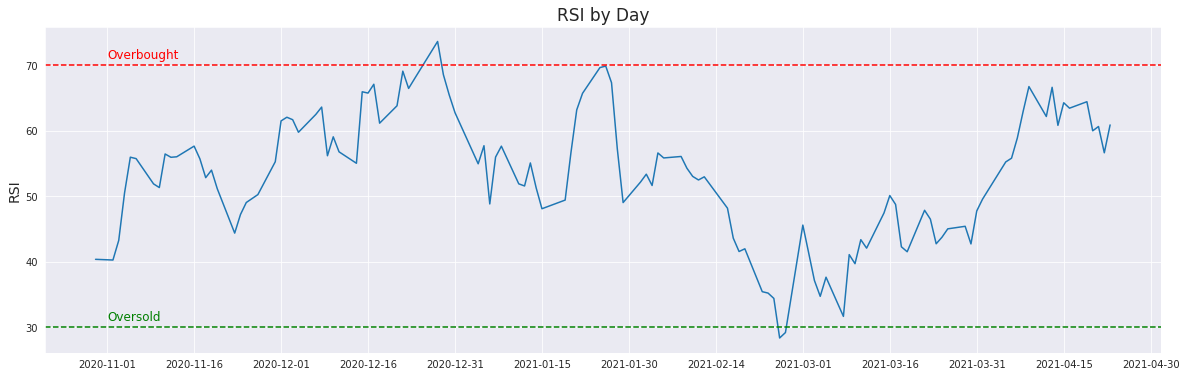

In [35]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(120)

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(example['rsi'])
ax.text(datetime(2020, 11, 1), 71,"Overbought" ,color="red", size="12")
ax.text(datetime(2020, 11, 1), 31, "Oversold" , color="green", size="12")
plt.axhline(y=70, color='r', linestyle='--')
plt.axhline(y=30, color='g', linestyle='--')
ax.set_title('RSI by Day', fontsize=17)
ax.set_ylabel('RSI', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.show()

In [36]:
# Aroon Oscillator
aroon = df.groupby('ticker').apply(lambda x: talib.AROONOSC(x['high'], x['low'], timeperiod=14)).reset_index()
df = pd.merge(
    df, aroon.drop('ticker', axis=1).set_index('level_1'), left_index=True, right_index=True, how='inner'
    ).rename(columns={0: 'aroon'})

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'high', 'low', 'close', 'aroon']] 
display.tail(10)

,date,ticker,high,low,close,aroon
13581,2021-04-12,AAPL,132.850,130.630,130.631,50.000
13586,2021-04-13,AAPL,134.660,131.930,133.806,64.286
13591,2021-04-14,AAPL,135.000,131.660,131.417,71.429
13596,2021-04-15,AAPL,135.000,133.640,133.876,78.571
13601,2021-04-16,AAPL,134.670,133.280,133.537,78.571
13606,2021-04-19,AAPL,135.470,133.340,134.214,92.857
13611,2021-04-20,AAPL,135.530,131.810,132.492,100.000
13616,2021-04-21,AAPL,133.750,131.300,132.880,92.857
13621,2021-04-22,AAPL,134.150,131.410,131.328,85.714
13626,2021-04-23,AAPL,135.120,132.160,133.697,78.571


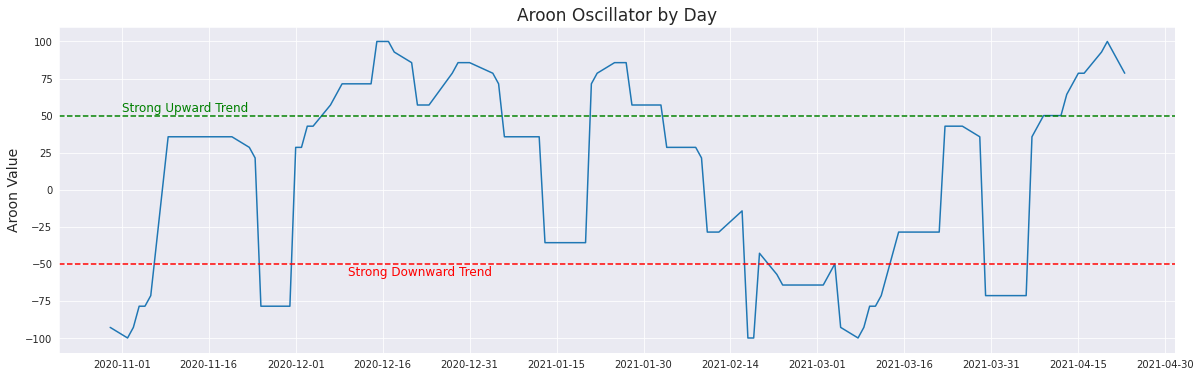

In [37]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(120)

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(example['aroon'])
ax.text(datetime(2020, 11, 1), 53, 'Strong Upward Trend', color='g', size=12)
ax.text(datetime(2020, 12, 10), -58, 'Strong Downward Trend', color='r', size=12)
plt.axhline(y=50, color='g', linestyle='--')
plt.axhline(y=-50, color='r', linestyle='--')
ax.set_title('Aroon Oscillator by Day', fontsize=17)
ax.set_ylabel('Aroon Value', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.show()

In [38]:
# Momentum
df['momentum'] = df.groupby('ticker')['close'].transform(lambda x: talib.MOM(x, timeperiod=14))

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'close', 'momentum']] 
display.tail()

,date,ticker,close,momentum
13606,2021-04-19,AAPL,134.214,13.388
13611,2021-04-20,AAPL,132.492,13.149
13616,2021-04-21,AAPL,132.880,11.297
13621,2021-04-22,AAPL,131.328,8.899
13626,2021-04-23,AAPL,133.697,8.381


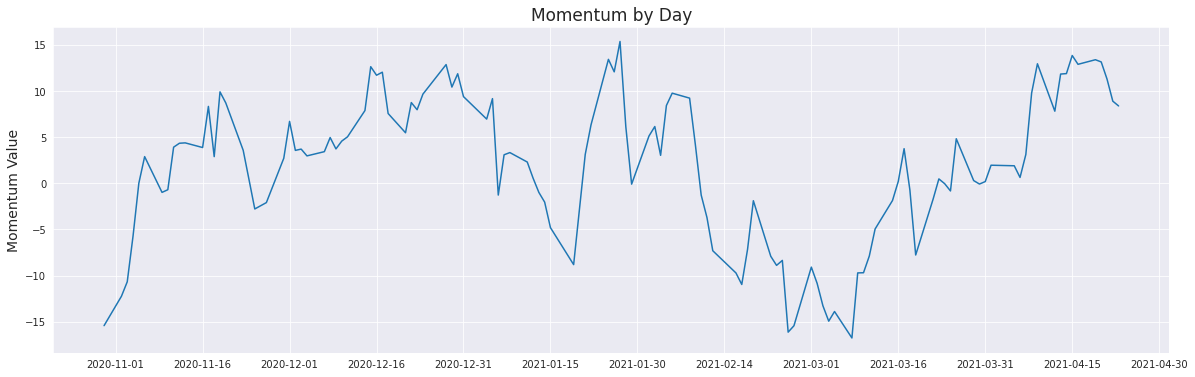

In [39]:
example = df.loc[df['ticker'] == 'AAPL'].set_index('date').tail(120)

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(example['momentum'])
ax.set_title('Momentum by Day', fontsize=17)
ax.set_ylabel('Momentum Value', fontsize=14)
ax.xaxis.set_major_locator(ticker.MultipleLocator(15))
plt.show()

### Cycle Indicators

In [40]:
# Hilbert Transform - Dominant Cycle Period
df['ht_dcperiod'] = df.groupby('ticker')['close'].transform(lambda x: talib.HT_DCPERIOD(x))

# Hilbert Transform - Dominant Cycle Phase
df['ht_dcphase'] = df.groupby('ticker')['close'].transform(lambda x: talib.HT_DCPHASE(x))

# Hilbert Transform - Phasor Components
df['ht_inphase'] = df.groupby('ticker')['close'].transform(lambda x: talib.HT_PHASOR(x)[0])
df['ht_quadrature'] = df.groupby('ticker')['close'].transform(lambda x: talib.HT_PHASOR(x)[1])

# Hilbert Transform - SineWave
df['ht_sine'] = df.groupby('ticker')['close'].transform(lambda x: talib.HT_SINE(x)[0])
df['ht_leadsine'] = df.groupby('ticker')['close'].transform(lambda x: talib.HT_SINE(x)[1])

# Hilbert Transform - Trend vs Cycle Mode
df['ht_trendmode'] = df.groupby('ticker')['close'].transform(lambda x: talib.HT_TRENDMODE (x))

display = df.loc[df['ticker'] == 'AAPL']
display = display[['date', 'ticker', 'close', 'ht_dcperiod', 'ht_inphase', 'ht_quadrature',
                   'ht_sine', 'ht_leadsine', 'ht_trendmode']] 
display.tail()

,date,ticker,close,ht_dcperiod,ht_inphase,ht_quadrature,ht_sine,ht_leadsine,ht_trendmode
13606,2021-04-19,AAPL,134.214,17.243,4.115,-2.597,-0.119,-0.786,1.000
13611,2021-04-20,AAPL,132.492,18.035,3.442,-2.394,-0.178,-0.822,1.000
13616,2021-04-21,AAPL,132.880,18.913,2.437,-3.241,-0.237,-0.855,1.000
13621,2021-04-22,AAPL,131.328,19.894,1.350,-1.570,-0.301,-0.887,1.000
13626,2021-04-23,AAPL,133.697,21.051,1.792,-1.086,-0.353,-0.911,1.000


In [41]:
df.columns.tolist()

['date',
 'ticker',
 'close',
 'volume',
 'high',
 'low',
 'open',
 'year',
 'qtr',
 'month',
 'week',
 'dow',
 'open_1',
 'open_2',
 'open_3',
 'open_4',
 'open_5',
 'high_1',
 'high_2',
 'high_3',
 'high_4',
 'high_5',
 'low_1',
 'low_2',
 'low_3',
 'low_4',
 'low_5',
 'close_1',
 'close_2',
 'close_3',
 'close_4',
 'close_5',
 'volume_1',
 'volume_2',
 'volume_3',
 'volume_4',
 'volume_5',
 'rolling_avg_open_4',
 'rolling_std_open_4',
 'rolling_median_open_4',
 'rolling_min_open_4',
 'rolling_max_open_4',
 'diff_open_1',
 'diff_open_4',
 'open_pct_change_1',
 'open_pct_change_4',
 'rolling_avg_high_4',
 'rolling_std_high_4',
 'rolling_median_high_4',
 'rolling_min_high_4',
 'rolling_max_high_4',
 'diff_high_1',
 'diff_high_4',
 'high_pct_change_1',
 'high_pct_change_4',
 'rolling_avg_low_4',
 'rolling_std_low_4',
 'rolling_median_low_4',
 'rolling_min_low_4',
 'rolling_max_low_4',
 'diff_low_1',
 'diff_low_4',
 'low_pct_change_1',
 'low_pct_change_4',
 'rolling_avg_close_4',
 'rolli

# New Section

In [42]:
len(df.columns.tolist())

164

In [43]:
df.tail()

,date,ticker,close,volume,high,low,open,year,qtr,month,week,dow,open_1,open_2,open_3,open_4,open_5,high_1,high_2,high_3,high_4,high_5,low_1,low_2,low_3,low_4,low_5,close_1,close_2,close_3,close_4,close_5,volume_1,volume_2,volume_3,volume_4,volume_5,rolling_avg_open_4,rolling_std_open_4,rolling_median_open_4,...,volume_ema_4,volume_ema_12,volume_dema_4,volume_dema_12,volume_tema_4,volume_tema_12,volume_trima_4,volume_trima_12,volume_wma_4,volume_wma_12,sma_crossover,bb_upper,bb_lower,bb_indicator,typical_price,weighted_close,mid_point,mid_price,ht_trendline,sar,adosc,obv,lin_reg,lin_reg_angle,lin_reg_intercept,lin_reg_slope,corr,beta,atr,annualized_vol,rsi,aroon,momentum,ht_dcperiod,ht_dcphase,ht_inphase,ht_quadrature,ht_sine,ht_leadsine,ht_trendmode
13629,2021-04-23,INTC,58.093,77479500.000,60.000,57.900,59.160,2021,2,4,16,4,63.350,62.790,63.640,64.700,65.330,63.910,63.780,63.760,64.740,65.520,62.280,62.300,62.410,63.070,64.570,61.359,62.467,61.486,62.398,63.497,38257600.000,24364200.000,19872100.000,23997700.000,24625500.000,62.235,2.080,63.070,...,48701491.139,35815068.752,61911664.862,41406322.848,69664690.304,47628884.076,37099200.000,28342678.571,49329130.000,35301460.256,1.000,63.560,58.761,1,58.664,58.522,62.516,63.195,63.579,63.195,-174079151.658,2823204500.000,60.471,-23.442,66.108,-0.434,0.843,1.102,2.319,0.393,36.235,-64.286,-7.159,16.871,-42.100,-0.879,0.751,-0.670,0.051,1.000
13626,2021-04-23,AAPL,133.697,78657500.000,135.120,132.160,132.160,2021,2,4,16,4,133.040,132.360,135.020,133.510,134.300,134.150,133.750,135.530,135.470,134.670,131.410,131.300,131.810,133.340,133.280,131.328,132.880,132.492,134.214,133.537,84566500.000,68847100.000,94812300.000,94264200.000,84922400.000,133.145,1.306,132.700,...,81590522.925,86549804.958,78933330.552,80870692.964,78547156.380,80669089.317,80049500.000,88766119.048,80083600.000,85618130.769,0.000,134.422,131.422,0,133.659,133.668,129.919,130.335,127.999,130.335,-115427812.391,17380925200.000,134.462,23.479,128.816,0.434,0.991,0.367,3.077,0.352,60.895,78.571,8.381,21.051,200.670,1.792,-1.086,-0.353,-0.911,1.000
13627,2021-04-23,AMZN,3340.880,3192800.000,3375.000,3308.500,3319.100,2021,2,4,16,4,3371.680,3316.000,3373.600,3390.330,3380.000,3372.870,3362.860,3382.990,3435.930,3406.800,3301.450,3303.810,3316.000,3360.160,3355.590,3309.040,3362.020,3334.690,3372.010,3399.440,2580600.000,2211200.000,2623000.000,2725400.000,3186000.000,3345.095,31.841,3345.390,...,2834201.416,2934363.206,2877882.714,2777249.326,3005949.562,2735719.269,2566566.667,3046521.429,2755840.000,2900714.103,0.000,3376.779,3310.677,0,3341.460,3341.315,3311.910,3326.485,3254.857,3326.485,-411733.441,688199000.000,3372.553,78.090,3310.914,4.741,0.992,0.619,67.357,0.325,57.833,71.429,114.150,21.116,209.209,18.220,-20.865,-0.488,-0.962,1.000
13628,2021-04-23,FB,301.130,17536800.000,302.590,297.150,298.760,2021,2,4,16,4,301.330,301.950,301.990,305.010,308.170,302.920,301.980,305.100,307.700,308.950,296.040,297.390,297.210,300.560,304.610,296.520,301.470,302.650,302.240,306.180,16375400.000,14863500.000,16796400.000,14553500.000,13059200.000,301.007,1.528,301.640,...,16417627.307,16501332.454,17025614.878,15308303.886,17425891.097,15651870.168,16135166.667,14983519.048,16579680.000,15568428.205,1.000,304.114,297.490,0,300.290,300.500,304.805,305.960,301.432,305.960,-951537.173,5317796400.000,299.443,-46.161,312.980,-1.041,0.986,0.184,7.340,0.368,54.361,-71.429,-7.780,19.953,253.618,-3.139,1.793,-0.959,-0.878,0.000
13630,2021-04-23,MSFT,259.576,21462600.000,261.510,257.270,257.880,2021,2,4,16,4,260.210,258.940,257.820,260.190,259.470,261.780,260.680,260.200,261.480,261.000,255.640,257.250,256.840,257.820,257.600,255.620,259.009,256.703,257.180,259.168,25606200.000,24030400.000,19722900.000,23209300.000,24878600.000,258.713,1.123,258.410,...,23029722.659,24304406.945,22618326.955,22365505.979,22524952.084,22244716.347,23409783.333,23980245.238,23045270.000,23526262.821,0.000,259.821,255.414,0,259.452,259.483,252.971,2